In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

2019-10-30 19:46:24,839 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:46:24,841 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:46:24,842 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [6]:
df_index = strategy.index.loc['1992':'2019-07']
df_index_return = strategy.ret.loc['1992':'2019-07']

# 2. Explore

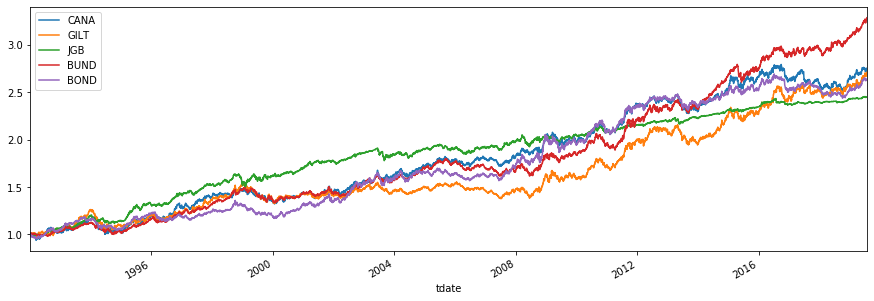

In [7]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

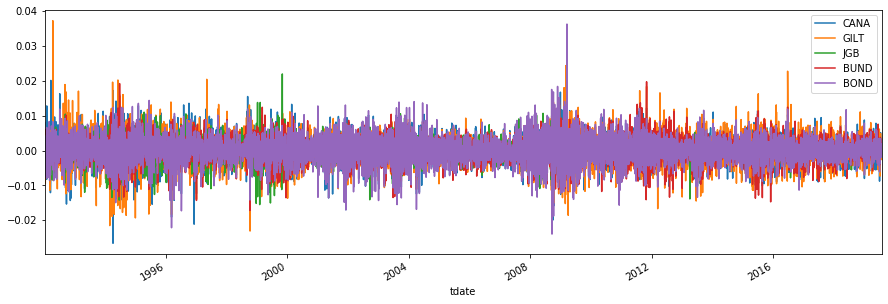

In [8]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [9]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### moving average 와 주가 차이

In [91]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [92]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [93]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [94]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="result/IPM_PAST.png">

<img src="result/IPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [117]:
one_week = 5
one_month = 20

In [118]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [119]:
    df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [120]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [121]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [122]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [123]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [124]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.672167	valid_1's binary_logloss: 0.672167
[20]	training's binary_logloss: 0.671437	valid_1's binary_logloss: 0.671437
[30]	training's binary_logloss: 0.670837	valid_1's binary_logloss: 0.670837
[40]	training's binary_logloss: 0.670282	valid_1's binary_logloss: 0.670282
[50]	training's binary_logloss: 0.669694	valid_1's binary_logloss: 0.669694
[60]	training's binary_logloss: 0.669184	valid_1's binary_logloss: 0.669184
[70]	training's binary_logloss: 0.668711	valid_1's binary_logloss: 0.668711
[80]	training's binary_logloss: 0.668226	valid_1's binary_logloss: 0.668226
[90]	training's binary_logloss: 0.667737	valid_1's binary_logloss: 0.667737
[100]	training's binary_logloss: 0.667273	valid_1's binary_logloss: 0.667273
[110]	training's binary_logloss: 0.66681	valid_1's binary_logloss: 0.66681
[120]	training's binary_logloss: 0.666369	valid_1's binary_logloss: 0.666369
[130]	training's binary_l

In [125]:
test_pred = model.predict(df_test_x.values)

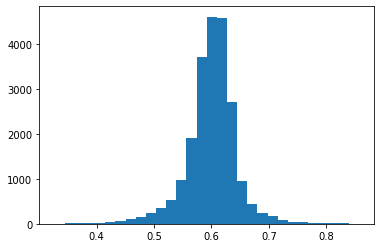

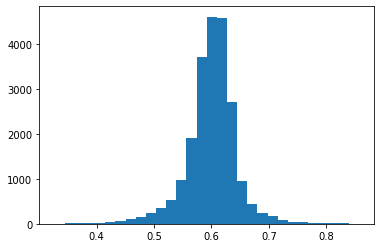

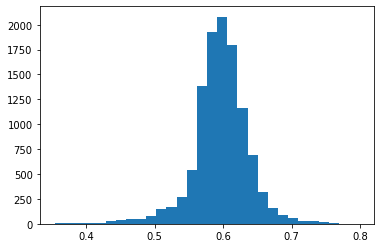

In [126]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [127]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [128]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [129]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [130]:
df_index_sub = df_index.loc['1994':]

In [131]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [132]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [133]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-30 19:52:02,684 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:52:02,684 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:52:02,684 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:52:02,684 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [134]:
tester = Tester(strategy)

In [135]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [136]:
strategy.set_portfolio_parameter(cs_strategy_type='vol')
strategy.make_portfolio()

2019-10-30 19:52:03,188 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:52:03,188 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:52:03,188 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:52:03,188 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:52:03,190 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:52:03,190 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:52:03,190 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:52:03,190 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:52:03,191 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:52:03,191 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:52:03,191 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:52:03,191 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:52:09,042 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 19:52:09,042 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 19:52:09,042 - IPM 

### TRAIN

2019-10-30 19:52:19,533 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:52:19,533 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:52:19,533 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:52:19,533 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:52:19,535 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:52:19,535 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:52:19,535 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:52:19,535 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:52:19,544 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:52:19,544 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:52:19,544 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:52:19,544 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:52:19,552 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:52:19,552 - IPM - INFO - [STEP 7]

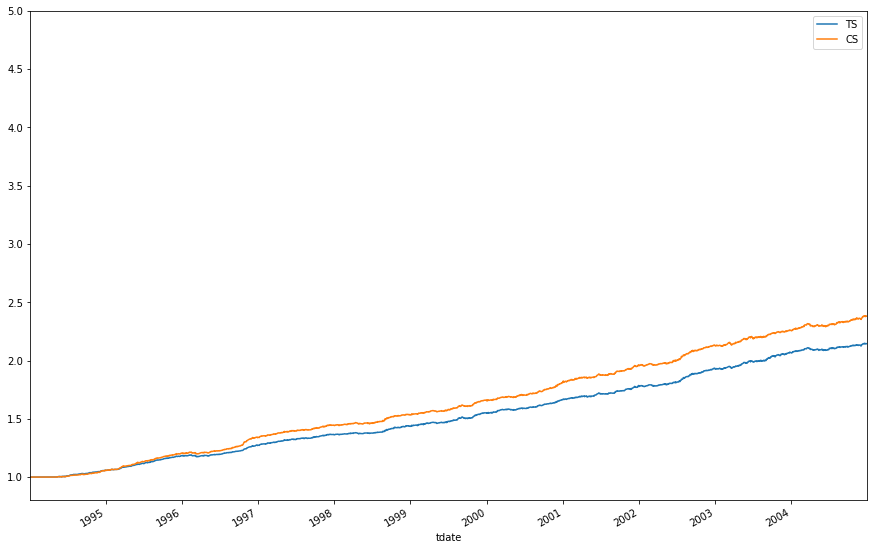

In [137]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2004-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-30 19:55:03,192 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:03,192 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:03,192 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:03,192 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:03,195 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:03,195 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:03,195 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:03,195 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:03,202 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:03,202 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:03,202 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:03,202 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:03,209 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:55:03,209 - IPM - INFO - [STEP 7]

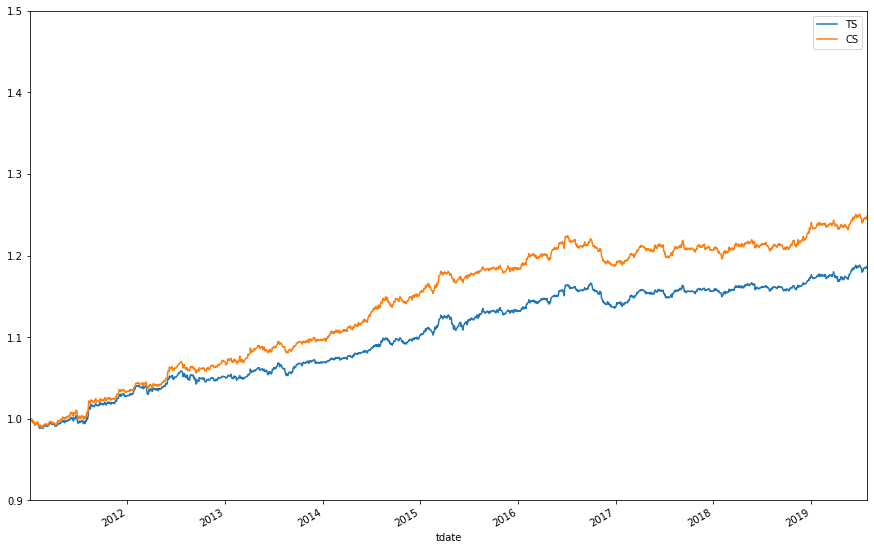

In [141]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [37]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [38]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [39]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [40]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [41]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [42]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [43]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.63501	valid_1's binary_logloss: 0.700881
[20]	training's binary_logloss: 0.633715	valid_1's binary_logloss: 0.700548
[30]	training's binary_logloss: 0.632555	valid_1's binary_logloss: 0.70025
[40]	training's binary_logloss: 0.631546	valid_1's binary_logloss: 0.699892
[50]	training's binary_logloss: 0.630584	valid_1's binary_logloss: 0.699557
[60]	training's binary_logloss: 0.629605	valid_1's binary_logloss: 0.699346
[70]	training's binary_logloss: 0.628735	valid_1's binary_logloss: 0.699113
[80]	training's binary_logloss: 0.627892	valid_1's binary_logloss: 0.698907
[90]	training's binary_logloss: 0.62696	valid_1's binary_logloss: 0.698677
[100]	training's binary_logloss: 0.626172	valid_1's binary_logloss: 0.698487
[110]	training's binary_logloss: 0.625396	valid_1's binary_logloss: 0.698225
[120]	training's binary_logloss: 0.624633	valid_1's binary_logloss: 0.698132
[130]	training's binary_lo

In [44]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([5.000e+00, 1.200e+01, 1.800e+01, 3.000e+01, 2.200e+01, 4.300e+01,
        3.600e+01, 5.100e+01, 5.000e+01, 7.700e+01, 8.900e+01, 1.210e+02,
        2.160e+02, 2.700e+02, 3.570e+02, 7.260e+02, 2.710e+03, 3.844e+03,
        5.318e+03, 6.042e+03, 5.453e+03, 3.768e+03, 2.124e+03, 9.870e+02,
        4.230e+02, 2.090e+02, 1.520e+02, 7.400e+01, 3.800e+01, 1.000e+01]),
 array([0.2611679 , 0.28197434, 0.30278079, 0.32358723, 0.34439367,
        0.36520011, 0.38600656, 0.406813  , 0.42761944, 0.44842588,
        0.46923233, 0.49003877, 0.51084521, 0.53165165, 0.5524581 ,
        0.57326454, 0.59407098, 0.61487742, 0.63568387, 0.65649031,
        0.67729675, 0.69810319, 0.71890963, 0.73971608, 0.76052252,
        0.78132896, 0.8021354 , 0.82294185, 0.84374829, 0.86455473,
        0.88536117]),
 <a list of 30 Patch objects>)

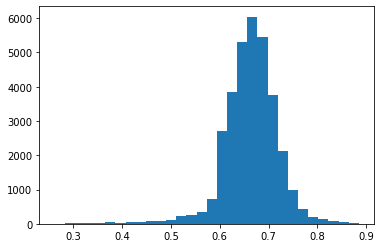

In [45]:
plt.hist(pred2, bins=30)

In [46]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [47]:
strategy2 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'

strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

2019-10-30 19:48:36,139 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:48:36,139 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:48:36,140 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:48:36,140 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:48:36,141 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:48:36,141 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [48]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='vol')
strategy2.make_portfolio()

2019-10-30 19:48:39,041 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:48:39,041 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:48:39,042 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:48:39,042 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:48:39,042 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:48:39,042 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:48:39,043 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:48:39,043 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:48:44,845 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 19:48:44,845 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 19:48:44,846 - IPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 19:48:44,846 - IPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 19:48:46,479 - IPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 19:48:46,479 - IPM - 

### TRAIN

2019-10-30 19:48:55,286 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:48:55,286 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:48:55,288 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:48:55,288 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:48:55,294 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:48:55,294 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:48:55,301 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:48:55,301 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT


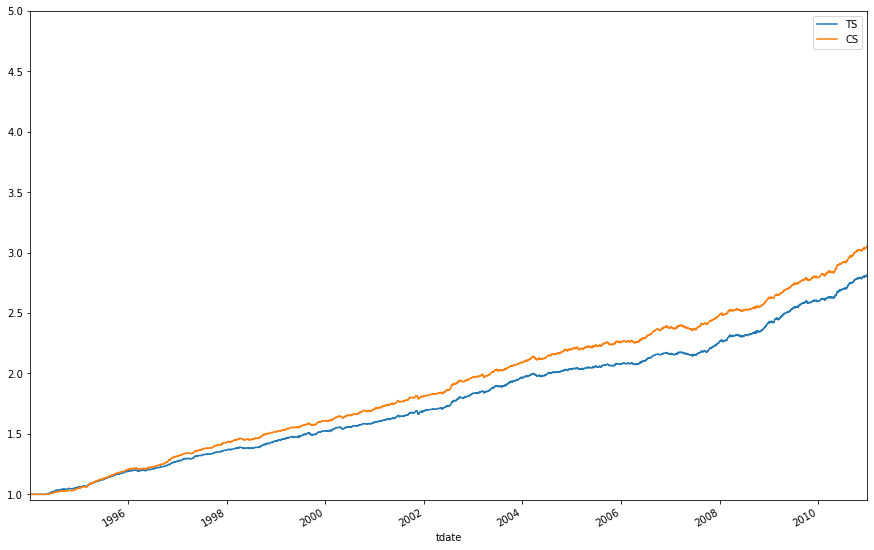

In [49]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-30 19:54:51,718 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:51,718 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:51,718 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:51,718 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:51,720 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:51,720 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:51,720 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:51,720 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:51,728 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:51,728 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:51,728 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:51,728 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:51,735 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:54:51,735 - IPM - INFO - [STEP 7]

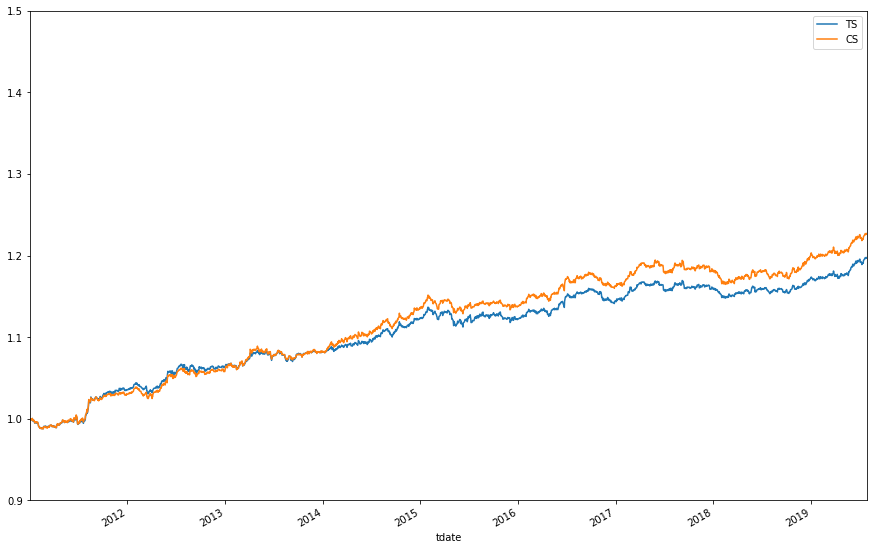

In [140]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 3. Case1을 Rolling으로 실행

In [51]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [52]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [53]:
models = []
train_preds = []
test_preds = []

In [54]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.672172	valid_1's binary_logloss: 0.673354
[20]	training's binary_logloss: 0.671459	valid_1's binary_logloss: 0.673775
[30]	training's binary_logloss: 0.670839	valid_1's binary_logloss: 0.674149
[40]	training's binary_logloss: 0.670264	valid_1's binary_logloss: 0.674328
[50]	training's binary_logloss: 0.6697	valid_1's binary_logloss: 0.674585
[60]	training's binary_logloss: 0.669187	valid_1's binary_logloss: 0.674845
[70]	training's binary_logloss: 0.668672	valid_1's binary_logloss: 0.675223
[80]	training's binary_logloss: 0.668207	valid_1's binary_logloss: 0.675402
[90]	training's binary_logloss: 0.667718	valid_1's binary_logloss: 0.675718
[100]	training's binary_logloss: 0.667235	valid_1's binary_logloss: 0.67607
[110]	training's binary_logloss: 0.666795	valid_1's binary_logloss: 0.676378
[120]	training's binary_logloss: 0.666382	valid_1's binary_logloss: 0.676634
[130]	training's binary_lo

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[20]	training's binary_logloss: 0.671724	valid_1's binary_logloss: 0.67292
[30]	training's binary_logloss: 0.671219	valid_1's binary_logloss: 0.672859
[40]	training's binary_logloss: 0.670712	valid_1's binary_logloss: 0.67272
[50]	training's binary_logloss: 0.670211	valid_1's binary_logloss: 0.672561
[60]	training's binary_logloss: 0.66973	valid_1's binary_logloss: 0.672529
[70]	training's binary_logloss: 0.669258	valid_1's binary_logloss: 0.672401
[80]	training's binary_logloss: 0.668827	valid_1's binary_logloss: 0.672332
[90]	training's binary_logloss: 0.668392	valid_1's binary_logloss: 0.672223
[100]	training's binary_logloss: 0.667922	valid_1's binary_logloss: 0.67234
[110]	training's binary_logloss: 0.667472	valid_1's binary_logloss: 0.672406
[120]	training's binary_logloss: 0.667054	valid_1's binary_logloss: 0.672384
[130]	training's binary_logloss: 0.666625	valid_1's binary_logloss: 0.672441
[140]	training's binary_logloss: 0.666196	valid_1's binary_logloss: 0.672509
[150]	trai

[240]	training's binary_logloss: 0.663144	valid_1's binary_logloss: 0.671866
[250]	training's binary_logloss: 0.662778	valid_1's binary_logloss: 0.671801
[260]	training's binary_logloss: 0.662443	valid_1's binary_logloss: 0.671717
[270]	training's binary_logloss: 0.662118	valid_1's binary_logloss: 0.671655
[280]	training's binary_logloss: 0.661791	valid_1's binary_logloss: 0.6716
[290]	training's binary_logloss: 0.661469	valid_1's binary_logloss: 0.671471
[300]	training's binary_logloss: 0.661153	valid_1's binary_logloss: 0.67141
[310]	training's binary_logloss: 0.660835	valid_1's binary_logloss: 0.671403
[320]	training's binary_logloss: 0.660502	valid_1's binary_logloss: 0.671299
[330]	training's binary_logloss: 0.660161	valid_1's binary_logloss: 0.671229
[340]	training's binary_logloss: 0.659849	valid_1's binary_logloss: 0.671229
[350]	training's binary_logloss: 0.659527	valid_1's binary_logloss: 0.671191
[360]	training's binary_logloss: 0.659229	valid_1's binary_logloss: 0.671201
[3

[450]	training's binary_logloss: 0.657532	valid_1's binary_logloss: 0.674588
[460]	training's binary_logloss: 0.657244	valid_1's binary_logloss: 0.674624
[470]	training's binary_logloss: 0.656948	valid_1's binary_logloss: 0.674646
[480]	training's binary_logloss: 0.656681	valid_1's binary_logloss: 0.674677
[490]	training's binary_logloss: 0.656383	valid_1's binary_logloss: 0.674627
[500]	training's binary_logloss: 0.656098	valid_1's binary_logloss: 0.674597
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.656098	valid_1's binary_logloss: 0.674597
Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.672452	valid_1's binary_logloss: 0.672963
[20]	training's binary_logloss: 0.671968	valid_1's binary_logloss: 0.672982
[30]	training's binary_logloss: 0.67152	valid_1's binary_logloss: 0.672917
[40]	training's binary_logloss: 0.671116	valid_1's binary_logloss: 0.672885
[50]	training's binary_logloss: 0.670727	valid_1

Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.672518	valid_1's binary_logloss: 0.680863
[20]	training's binary_logloss: 0.672096	valid_1's binary_logloss: 0.680658
[30]	training's binary_logloss: 0.67171	valid_1's binary_logloss: 0.680548
[40]	training's binary_logloss: 0.671351	valid_1's binary_logloss: 0.68039
[50]	training's binary_logloss: 0.671005	valid_1's binary_logloss: 0.680288
[60]	training's binary_logloss: 0.670629	valid_1's binary_logloss: 0.680201
[70]	training's binary_logloss: 0.670298	valid_1's binary_logloss: 0.680215
[80]	training's binary_logloss: 0.669949	valid_1's binary_logloss: 0.680218
[90]	training's binary_logloss: 0.669621	valid_1's binary_logloss: 0.680082
[100]	training's binary_logloss: 0.669276	valid_1's binary_logloss: 0.680048
[110]	training's binary_logloss: 0.668947	valid_1's binary_logloss: 0.680032
[120]	training's binary_logloss: 0.668622	valid_1's binary_logloss: 0.680042
[130]	training's binary_l

In [55]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([5.000e+00, 1.000e+00, 4.000e+00, 8.000e+00, 8.000e+00, 2.800e+01,
        2.200e+01, 3.300e+01, 4.500e+01, 6.400e+01, 1.110e+02, 1.980e+02,
        3.750e+02, 1.388e+03, 1.841e+03, 1.848e+03, 1.614e+03, 1.409e+03,
        9.580e+02, 5.520e+02, 2.990e+02, 1.620e+02, 8.300e+01, 5.800e+01,
        1.800e+01, 1.100e+01, 9.000e+00, 1.000e+00, 4.000e+00, 3.000e+00]),
 array([0.35887242, 0.37361507, 0.38835772, 0.40310036, 0.41784301,
        0.43258565, 0.4473283 , 0.46207094, 0.47681359, 0.49155623,
        0.50629888, 0.52104153, 0.53578417, 0.55052682, 0.56526946,
        0.58001211, 0.59475475, 0.6094974 , 0.62424004, 0.63898269,
        0.65372533, 0.66846798, 0.68321063, 0.69795327, 0.71269592,
        0.72743856, 0.74218121, 0.75692385, 0.7716665 , 0.78640914,
        0.80115179]),
 <a list of 30 Patch objects>)

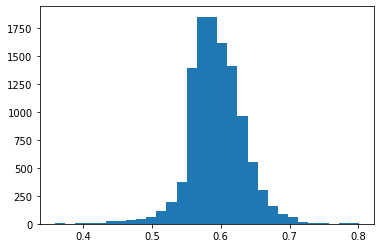

In [56]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [57]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [58]:
strategy3 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'

strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-10-30 19:49:01,222 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:49:01,222 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:49:01,222 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:49:01,224 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:49:01,224 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:49:01,224 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:49:01,226 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:49:01,226 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:49:01,226 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [59]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='vol')
strategy3.make_portfolio()

2019-10-30 19:49:01,257 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:49:01,257 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:49:01,257 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:49:01,260 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:49:01,260 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:49:01,260 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:49:01,261 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:49:01,261 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:49:01,261 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:49:01,263 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:49:01,263 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:49:01,263 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:49:06,991 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 19:49:06,991 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 19:49:06,991 - IPM -

2019-10-30 19:55:23,520 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:23,520 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:23,520 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:23,520 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:23,522 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:23,522 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:23,522 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:23,522 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:23,529 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:23,529 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:23,529 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:23,529 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:23,537 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:55:23,537 - IPM - INFO - [STEP 7]

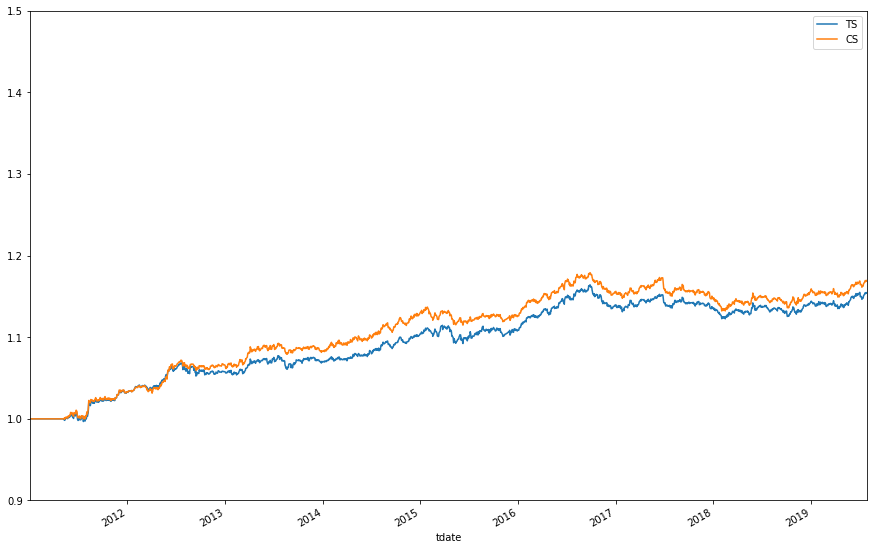

In [142]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 4. CASE 2를 ROLLING으로 실행

In [61]:
models = []
train_preds = []
test_preds = []

In [62]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.63501	valid_1's binary_logloss: 0.681508
[20]	training's binary_logloss: 0.633715	valid_1's binary_logloss: 0.67992
[30]	training's binary_logloss: 0.632555	valid_1's binary_logloss: 0.679119
[40]	training's binary_logloss: 0.631546	valid_1's binary_logloss: 0.677843
[50]	training's binary_logloss: 0.630584	valid_1's binary_logloss: 0.677344
[60]	training's binary_logloss: 0.629605	valid_1's binary_logloss: 0.678027
[70]	training's binary_logloss: 0.628735	valid_1's binary_logloss: 0.678489
[80]	training's binary_logloss: 0.627892	valid_1's binary_logloss: 0.679339
[90]	training's binary_logloss: 0.62696	valid_1's binary_logloss: 0.680657
[100]	training's binary_logloss: 0.626172	valid_1's binary_logloss: 0.681014
[110]	training's binary_logloss: 0.625396	valid_1's binary_logloss: 0.681062
[120]	training's binary_logloss: 0.624633	valid_1's binary_logloss: 0.682017
[130]	training's binary_lo

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.635258	valid_1's binary_logloss: 0.682658
[20]	training's binary_logloss: 0.634163	valid_1's binary_logloss: 0.682563
[30]	training's binary_logloss: 0.633214	valid_1's binary_logloss: 0.682652
[40]	training's binary_logloss: 0.632262	valid_1's binary_logloss: 0.68268
[50]	training's binary_logloss: 0.631372	valid_1's binary_logloss: 0.682726
[60]	training's binary_logloss: 0.630419	valid_1's binary_logloss: 0.683122
[70]	training's binary_logloss: 0.629595	valid_1's binary_logloss: 0.682756
[80]	training's binary_logloss: 0.628753	valid_1's binary_logloss: 0.681971
[90]	training's binary_logloss: 0.627935	valid_1's binary_logloss: 0.680625
[100]	training's binary_logloss: 0.627055	valid_1's binary_logloss: 0.680166
[110]	training's binary_logloss: 0.626312	valid_1's binary_logloss: 0.678058
[120]	training's binary_logloss: 0.625618	valid_1's binary_logloss: 0.676298
[130]	training's binary_

[60]	training's binary_logloss: 0.63063	valid_1's binary_logloss: 0.675907
[70]	training's binary_logloss: 0.629792	valid_1's binary_logloss: 0.675053
[80]	training's binary_logloss: 0.628993	valid_1's binary_logloss: 0.675029
[90]	training's binary_logloss: 0.628224	valid_1's binary_logloss: 0.674539
[100]	training's binary_logloss: 0.627417	valid_1's binary_logloss: 0.673517
[110]	training's binary_logloss: 0.626508	valid_1's binary_logloss: 0.671711
[120]	training's binary_logloss: 0.625682	valid_1's binary_logloss: 0.670824
[130]	training's binary_logloss: 0.624778	valid_1's binary_logloss: 0.671015
[140]	training's binary_logloss: 0.623955	valid_1's binary_logloss: 0.670475
[150]	training's binary_logloss: 0.623178	valid_1's binary_logloss: 0.669878
[160]	training's binary_logloss: 0.622476	valid_1's binary_logloss: 0.670545
[170]	training's binary_logloss: 0.621756	valid_1's binary_logloss: 0.671419
[180]	training's binary_logloss: 0.621042	valid_1's binary_logloss: 0.671861
[190

[250]	training's binary_logloss: 0.616904	valid_1's binary_logloss: 0.691733
[260]	training's binary_logloss: 0.6163	valid_1's binary_logloss: 0.690016
[270]	training's binary_logloss: 0.615694	valid_1's binary_logloss: 0.690183
[280]	training's binary_logloss: 0.615196	valid_1's binary_logloss: 0.690353
[290]	training's binary_logloss: 0.614572	valid_1's binary_logloss: 0.690529
[300]	training's binary_logloss: 0.613956	valid_1's binary_logloss: 0.690478
[310]	training's binary_logloss: 0.613429	valid_1's binary_logloss: 0.690247
[320]	training's binary_logloss: 0.612842	valid_1's binary_logloss: 0.690141
[330]	training's binary_logloss: 0.612333	valid_1's binary_logloss: 0.690057
[340]	training's binary_logloss: 0.6118	valid_1's binary_logloss: 0.689539
[350]	training's binary_logloss: 0.611296	valid_1's binary_logloss: 0.689801
[360]	training's binary_logloss: 0.610811	valid_1's binary_logloss: 0.688813
[370]	training's binary_logloss: 0.610226	valid_1's binary_logloss: 0.688783
[38

[410]	training's binary_logloss: 0.609782	valid_1's binary_logloss: 0.675444
[420]	training's binary_logloss: 0.609348	valid_1's binary_logloss: 0.67553
[430]	training's binary_logloss: 0.608871	valid_1's binary_logloss: 0.676013
[440]	training's binary_logloss: 0.608417	valid_1's binary_logloss: 0.676113
[450]	training's binary_logloss: 0.60801	valid_1's binary_logloss: 0.676241
[460]	training's binary_logloss: 0.607542	valid_1's binary_logloss: 0.67636
[470]	training's binary_logloss: 0.607119	valid_1's binary_logloss: 0.676487
[480]	training's binary_logloss: 0.606712	valid_1's binary_logloss: 0.676528
[490]	training's binary_logloss: 0.606301	valid_1's binary_logloss: 0.676673
[500]	training's binary_logloss: 0.605903	valid_1's binary_logloss: 0.676825
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.605903	valid_1's binary_logloss: 0.676825
Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.635436	valid

In [63]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [64]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [66]:
strategy4 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'

strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-10-30 19:49:15,335 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:49:15,335 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:49:15,335 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:49:15,335 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:49:15,337 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:49:15,337 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:49:15,337 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:49:15,337 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:49:15,339 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:49:15,339 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:49:15,339 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:49:15,339 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [67]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='vol')
strategy4.make_portfolio()

2019-10-30 19:49:15,368 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:49:15,368 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:49:15,368 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:49:15,368 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:49:15,369 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:49:15,369 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:49:15,369 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:49:15,369 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:49:15,371 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:49:15,371 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:49:15,371 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:49:15,371 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:49:15,372 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:49:15,372 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:49:15,372 - IPM - INFO -

2019-10-30 19:55:29,568 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:29,568 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:29,568 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:29,568 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:55:29,570 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:29,570 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:29,570 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:29,570 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:55:29,577 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:29,577 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:29,577 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:29,577 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:55:29,584 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:55:29,584 - IPM - INFO - [STEP 7]

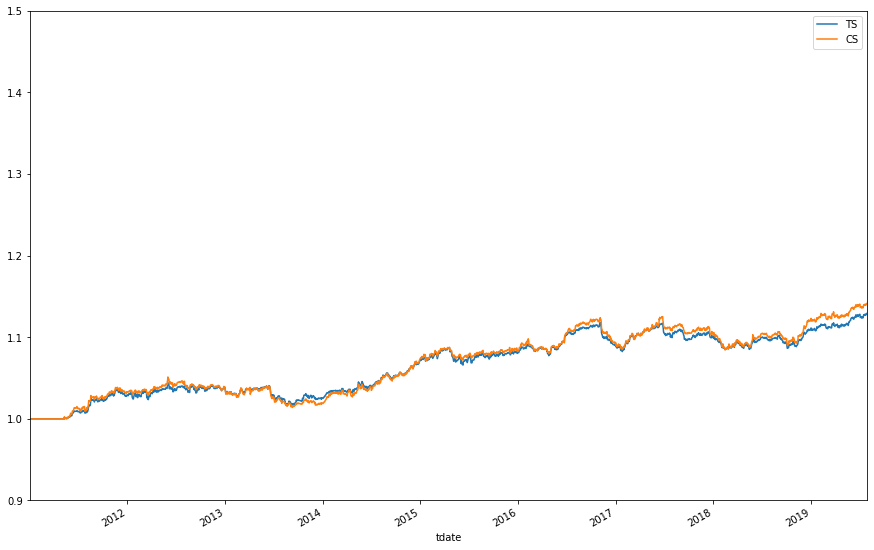

In [143]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))